In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.optim as optim

plt.rcParams['font.size'] = 16

### 1 - Solução analítica da $\dfrac{dT}{dt}=r(T_{amb}-T)$

Esta é uma equação diferencial linear de primeira ordem. Resolvendo-a com a condição inicial de que no tempo $t=0$ a temperatura do corpo é $T_0$, obtemos a seguinte solução particular:
$$
T(t)=T_{amb}+(T_0-T_{amb})e^{-rt}
$$
Esta solução mostra como a temperatura do corpo ($T$) se aproxima exponencialmente da temperatura ambiente ($T_{amb}$) ao longo do tempo ($t$). O termo $(T_0-T_{amb})$ representa a diferença inicial de temperatura, e o termo $e^{-rt}$ governa a taxa na qual essa diferença diminui com o tempo.

### 2 - Solução numérica via Runge-Kutta de quarta ordem (RK45)

In [2]:
# Define a EDO

def dTdt(t, T, r, Tamb):
    return r * (Tamb - T)

In [3]:
r = 0.005   # [1/s]
Tamb = 25   # Temperatura ambiente
T0 = 90     # Temperatura inicial
t = (0, 1500)
Dt = np.linspace(t[0], t[1], 100000)

In [4]:
sol = solve_ivp(dTdt, t, [T0], args=(r, Tamb), t_eval=Dt, method='RK45')
T = sol.y[0]
T_analytical = Tamb + (T0 - Tamb) * np.exp(-r * Dt)

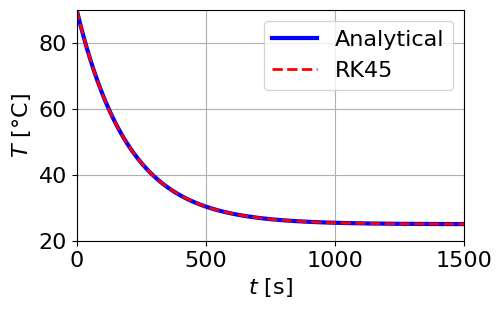

In [5]:
plt.figure(figsize=(5, 3))
plt.plot(Dt, T_analytical, label='Analytical', ls='-', lw=3, c='b')
plt.plot(Dt, T, label='RK45', ls='--', lw=2, c='r')
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$T$ [°C]")
plt.legend()
plt.xlim(t[0], t[1])
plt.ylim(20, T0)
plt.grid(True)
plt.show()

### 3 - Gerar dados de treinamento com ruído

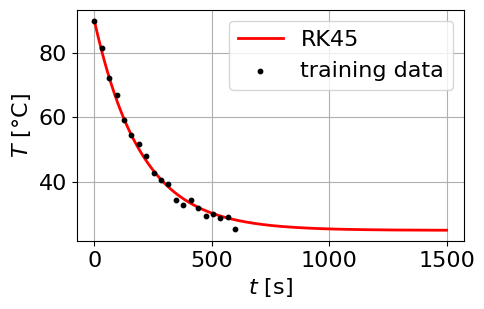

In [29]:
# Dados de treinamento
n_points = 20
t_train = np.linspace(0, 600, n_points)
T_sampled = np.interp(t_train, Dt, T)
T_noisy = T_sampled + np.random.normal(0, 1, size=t_train.shape)

# Para visualização
plt.figure(figsize=(5, 3))
plt.plot(Dt, T, label='RK45', lw=2, c='r')
plt.scatter(t_train, T_noisy, color='k', label='training data', zorder=5, s=10)
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$T$ [°C]")
plt.legend()
plt.grid(True)
plt.show()

### 4 - Aplicando a NN simples

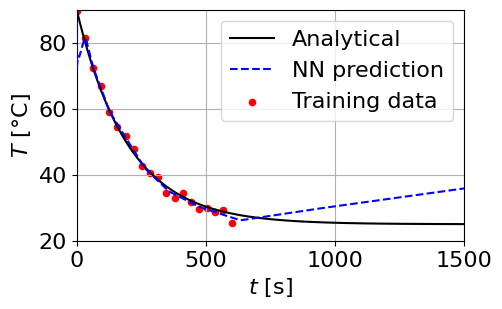

In [30]:
# Converter os dados para tensores
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
T_train_tensor = torch.tensor(T_noisy, dtype=torch.float32).view(-1, 1)

# === Normalização de t_train ===
t_train_norm = (t_train_tensor - t_train_tensor.min()) / (t_train_tensor.max() - t_train_tensor.min())

# Rede neural simples
model = nn.Sequential(
    nn.Linear(1, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)

# Função de perda
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Treinamento
for epoch in range(5000):
    model.train()
    optimizer.zero_grad()
    output = model(t_train_tensor)
    loss = criterion(output, T_train_tensor)
    loss.backward()
    optimizer.step()

# Previsão para extrapolação
t_test = torch.linspace(0, 1500, 100000).unsqueeze(1)
T_pred = model(t_test).detach().numpy()

# Plot
plt.figure(figsize=(5, 3))
plt.plot(Dt, T_analytical, label='Analytical', color='k')
plt.plot(t_test, T_pred, label='NN prediction', color='blue', ls='--', zorder=100)
plt.scatter(t_train, T_noisy, label='Training data', color='red', s=20)
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$T$ [°C]")
plt.xlim(t[0], t[1])
plt.ylim(20, T0)
plt.legend()
plt.grid(True)
plt.show()

### 5 - Aplicando a PINN

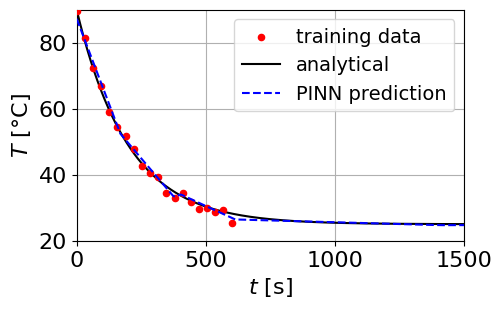

In [32]:
# Converter os dados para tensores
t_train_tensor_PINN = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
T_train_tensor_PINN = torch.tensor(T_noisy, dtype=torch.float32).view(-1, 1)

# === Normalização de t_train ===
t_train_norm_PINN = (t_train_tensor_PINN - t_train_tensor_PINN.min()) / (t_train_tensor_PINN.max() - t_train_tensor_PINN.min())

# Definição da Rede PINN

model_PINN = nn.Sequential(
    nn.Linear(1, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_PINN.parameters(), lr=0.01)

def grad(outputs, inputs):
    """Computa a derivada parcial de uma saída em relação a uma entrada."""
    return torch.autograd.grad(
        outputs, 
        inputs, 
        grad_outputs=torch.ones_like(outputs), 
        create_graph=True
    )[0]

def physics_loss(model_PINN, r, Tamb):
    """Calcula a perda física da PINN."""
    # Pontos de colocation
    ts = torch.linspace(0, 1500, steps=10000).view(-1, 1).requires_grad_(True)
    # Previsão da rede
    temps = model_PINN(ts)
    # Cálculo da derivada dT/dt
    dT = grad(temps, ts)
    # Penalização para que a equação diferencial seja respeitada
    ode_residual = dT - r * (Tamb - temps)
    return torch.mean(ode_residual**2)

# Treinamento com a nova perda física
for epoch in range(10000):
    optimizer.zero_grad()
    loss_data = criterion(model_PINN(t_train_norm_PINN), T_train_tensor_PINN)
    loss_physics = physics_loss(model_PINN, 0.005, 25)
    loss = loss_data + loss_physics  
    loss.backward()
    optimizer.step()

# Geração dos pontos de teste
t_test = torch.linspace(0, 1500, 100000).unsqueeze(1)
t_test_norm_PINN = (t_test - t_train_tensor_PINN.min()) / (t_train_tensor_PINN.max() - t_train_tensor_PINN.min())
# Previsão
T_pinn_pred = model_PINN(t_test_norm_PINN).detach().numpy()

# Plotagem
plt.figure(figsize=(5, 3))
plt.scatter(t_train, T_noisy, color='red', label='training data', marker='o', s=20, zorder=99)
plt.plot(Dt, T_analytical, color='k', label='analytical')
plt.plot(t_test.numpy(), T_pinn_pred, color='blue', ls='--', label='PINN prediction', zorder=100)
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$T$ [°C]")
plt.xlim(t[0], t[1])
plt.ylim(20, T0)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()